In [ ]:
import os
import random
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

sys.path.append("..")
import warnings

import wandb
from otc.metrics.metrics import effective_spread
from scipy.stats import wilcoxon
from tqdm.auto import tqdm


In [ ]:
# set here globally
EXCHANGE = "ise" # "ise"
MODELS = ["classical"] # ["classical"] # ["fttransformer", "gbm","classical"]
SUBSET = "all"  # "all"
STRATEGY = "supervised" # "transfer" #  

RETRAIN = False

In [ ]:
KEY = f"{EXCHANGE}_{STRATEGY}_{SUBSET}"
DATASET = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_raw:latest"

os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

run = wandb.init(project="thesis", entity="fbv")

# load unscaled data
artifact = run.use_artifact(DATASET)  # type: ignore
data_dir = artifact.download()

# load results
result_dirs = []
for model in MODELS:
    # retraining is only possible for gbm
    if model == "gbm" and RETRAIN:
        results = f"fbv/thesis/{EXCHANGE}_{model}_{STRATEGY}_{SUBSET}_retrain:latest"
    else:
        results = f"fbv/thesis/{EXCHANGE}_{model}_{STRATEGY}_{SUBSET}:latest"
    artifact = run.use_artifact(results)  # type: ignore
    result_dir = artifact.download()
    result_dirs.append(result_dir)


In [ ]:
# p. 35-38
COLUMNS = [
    "buy_sell",
    "EXPIRATION",
    "QUOTE_DATETIME",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "ask_ex",
    "ask_size_ex",
    "bid_ex",
    "bid_size_ex",
    "myn",
    "OPTION_TYPE",
    "issue_type",
]


if SUBSET == "all":
    train = pd.read_parquet(
        Path(data_dir, "train_set"), engine="fastparquet", columns=COLUMNS
    )
    val = pd.read_parquet(
        Path(data_dir, "val_set"), engine="fastparquet", columns=COLUMNS
    )
    test = pd.read_parquet(
        Path(data_dir, "test_set"), engine="fastparquet", columns=COLUMNS
    )
    eval_data = pd.concat([train, val, test])
    del train, val, test

elif SUBSET == "test":
    eval_data = pd.read_parquet(
        Path(data_dir, "test_set"), engine="fastparquet", columns=COLUMNS
    )


results = []
for i, model in tqdm(enumerate(MODELS)):
    result = pd.read_parquet(Path(result_dirs[i], "results"), engine="fastparquet")
    result.columns = pd.MultiIndex.from_product([[model], result.columns])
    results.append(result)

results_data = pd.concat(results, axis=1, names=MODELS)

assert len(eval_data) == len(results_data)

X_print = eval_data

del results


In [ ]:
# FIXME: select a subset of results for testing.
results_data = results_data[
    [
        # ("fttransformer", "fttransformer(classical)"),
        # ("fttransformer", "fttransformer(classical-size)"),
        # ("fttransformer", "fttransformer(ml)"),        
        # ("gbm", "gbm(classical)"),
        # ("gbm", "gbm(classical-size)"),
        # ("gbm", "gbm(ml)"),
        # # ("gbm", "gbm(classical-retraining)"),
        # # ("gbm", "gbm(classical-size-retraining)"),
        # # ("gbm", "gbm(ml-retraining)"),
        # ("gbm", "gbm(semi-classical)"),
        # ("gbm",'gbm(semi-classical-size)'),
        # ("gbm",'gbm(semi-ml)'),

#         # viz
        ("classical", "tick(all)"),
    
        ("classical", "quote(best)"),
        ("classical", "quote(ex)"),
        ("classical", "quote(best)->quote(ex)->rev_tick(all)"),
        (
            "classical",
            "trade_size(ex)->quote(best)->quote(ex)->depth(best)->depth(ex)->rev_tick(all)",
        ),       

#         # batch 1 / detailled analysis
#         ("classical", "tick(ex)"),
#         ("classical", "rev_tick(ex)"),
#         ("classical", "quote(ex)"),
#         ("classical", "lr(ex)"),
#         ("classical", "rev_lr(ex)"),
#         ("classical", "emo(ex)"),
#         ("classical", "rev_emo(ex)"),
        
#         # batch 2
#         ("classical", "clnv(ex)"),
#         ("classical", "rev_clnv(ex)"),
#         ("classical", "tick(all)"),
#         ("classical", "rev_tick(all)"),
#         ("classical", "quote(best)"),
#         ("classical", "lr(best)"),
#         ("classical", "rev_lr(best)"),
        
#         # batch 3
#         ("classical", "emo(best)"),
#         ("classical", "rev_emo(best)"),
#         ("classical", "clnv(best)"),
#         ("classical", "rev_clnv(best)"), 
        # ("classical", "quote(best)->quote(ex)->rev_tick(all)"),
        # (
        #     "classical",
        #     "trade_size(ex)->quote(best)->quote(ex)->depth(best)->depth(ex)->rev_tick(all)",
        # ),
        
        # detailed analysis
        
    ]
]


In [ ]:
LUT = {
    "Trade_Size(ex)->Quote(Best)->Depth(Best)->Quote(Ex)->Depth(Ex)->Rev_Tick(All)": "\gls{GBM}",
    "(Ex)": " (Ex)",
    "(Best)": " (Best)",
    "(Classical)": " (Classical)",
    "(Classical-Size)": " (Classical, Size)",
    "Rev_": "Rev. ",
    "Trade_Size": "Trade Size",
    "Depth": "Depth",
    "->": " $\\to$ ",
    "Lr": "\gls{LR}",
    "Emo": "\gls{EMO}",
    "Clnv": "\gls{CLNV}",
    "OPTION_TYPE": "Option Type",
    "_": "$\_",
    "Gbm": "\gls{GBM}",
}

LUT_INDEX = {
    "OPTION_TYPE": "Option Type",
    "issue_type": "Security Type",
    "TRADE_SIZE_binned": "Trade Size",
    "year_binned": "Year",
    "ttm_binned": "Time to Maturity",
    "myn_binned": "Moneyness",
    "prox_q_binned": "Location to Quote",
    "all": "All trades",
}


def cell_str(x):
    x = x.title()
    for orig, sub in LUT.items():
        x = x.replace(orig, sub)
    # title-case everything
    return x


def highlight_max(s, props=""):
    return np.where(s == np.nanmax(s.values), props, "")


In [ ]:
def set_tex_style(styler, caption, label, bold_axis=1):
    res = styler.set_caption(caption)

    res = (
        res.apply(highlight_max, props="font-weight:bold;", axis=bold_axis)
        .format(precision=4, decimal=".", thousands=",", escape=False, hyperlinks=None)
        .format_index(cell_str, axis=0)
        .format_index(cell_str, axis=1)
        .to_latex(
            f"{label}.tex",
            siunitx=True,
            position_float="centering",
            hrules=True,
            clines="skip-last;data",
            label="tab:" + label,
            caption=caption,
            convert_css=True,
        )
    )
    return res


In [ ]:
classifiers = results_data.columns.tolist()
criterions = list(LUT_INDEX)


## Common Sample

In [ ]:
mask = ~ X_print[classifiers].eq(0).any(axis=1)

In [ ]:
X_common = X_print[mask]

In [ ]:
X_common.head()

In [ ]:
results = []
for classifier in tqdm(classifiers):
    res = (
        X_common.groupby(["date"])[["buy_sell", classifier]]
        .apply(
                lambda x: accuracy_score(x["buy_sell"].astype("int8"), x[classifier])
        )
        .mul(100)
        .rename(classifier)
    )
    results.append(res)

In [ ]:
accuracies_over_time_common = pd.concat(results, axis=1)
accuracies_over_time_common.columns = accuracies_over_time_common.columns.get_level_values(1)
accuracies_over_time_common.index = pd.to_datetime(na_over_time.index)

In [ ]:
accuracies_over_time_common.plot()

In [ ]:
output_path = (
    f"gs://thesis-bucket-option-trade-classification/data/results/{KEY}-accuracies-over-time-common.parquet"
)
accuracies_over_time_common.to_parquet(output_path)

result_set = wandb.Artifact(name=f"{KEY}-classical-accuracies-over-time-common", type="results")
result_set.add_reference(output_path, name="results")
run.log_artifact(result_set)


## Unclassified by method

In [ ]:
unclassified = (
    (results_data[results_data == 0.0].count(axis=0) / len(results_data.index))
    # .sort_values(ascending=False)
    .to_frame(name="unclassified")
)

# coverage in %
unclassified = 100 - (unclassified * 100)

In [ ]:
unclassified.style.pipe(
    set_tex_style,
    caption=(f"{KEY}-unclassified-long", "{key}-unclassified-short"),
    label=f"{KEY.lower()}-unclassfied",
    bold_axis=0,
)
unclassified


In [ ]:
X_print["all"] = "all"
X_print["date"] = X_print["QUOTE_DATETIME"].dt.date

X_print = pd.concat([X_print, results_data], axis=1)

In [ ]:
results = []
for classifier in tqdm(classifiers):
    res = (
        X_print.groupby(["date"])[[classifier]].agg(lambda x: x.eq(0).mean()) #  x.isna().mean() * 100)
        # .rename(classifier)
    )
    results.append(res)

In [ ]:
na_over_time = pd.concat(results, axis=1)
na_over_time.columns = na_over_time.columns.get_level_values(1)
na_over_time.index = pd.to_datetime(na_over_time.index)

In [ ]:
na_over_time.plot()

In [ ]:
output_path = (
    f"gs://thesis-bucket-option-trade-classification/data/results/{KEY}-missing-over-time.parquet"
)
na_over_time.to_parquet(output_path)

result_set = wandb.Artifact(name=f"{KEY}-classical-na-over-time", type="results")
result_set.add_reference(output_path, name="results")
run.log_artifact(result_set)

wandb.finish()

## Fill in unclassified

Unclassified are `0`.

In [ ]:
rng = np.random.default_rng(42)

# replace 0 -> nan -> [-1,1]
results_data.replace(0, np.nan, inplace=True)
# assume same filler for every column
filler = pd.Series(
        rng.choice(a=[-1, 1], size=results_data.shape[0]),
        index=results_data.index,
        # columns=results_data.columns,
)

# do column-wise as we run out of memory otherwise
for classifier in tqdm(classifiers):
    results_data[classifier].fillna(filler, inplace=True)


## McNemar's Test

In [ ]:
Y = X_print[[*results_data.columns.tolist(), "buy_sell"]]

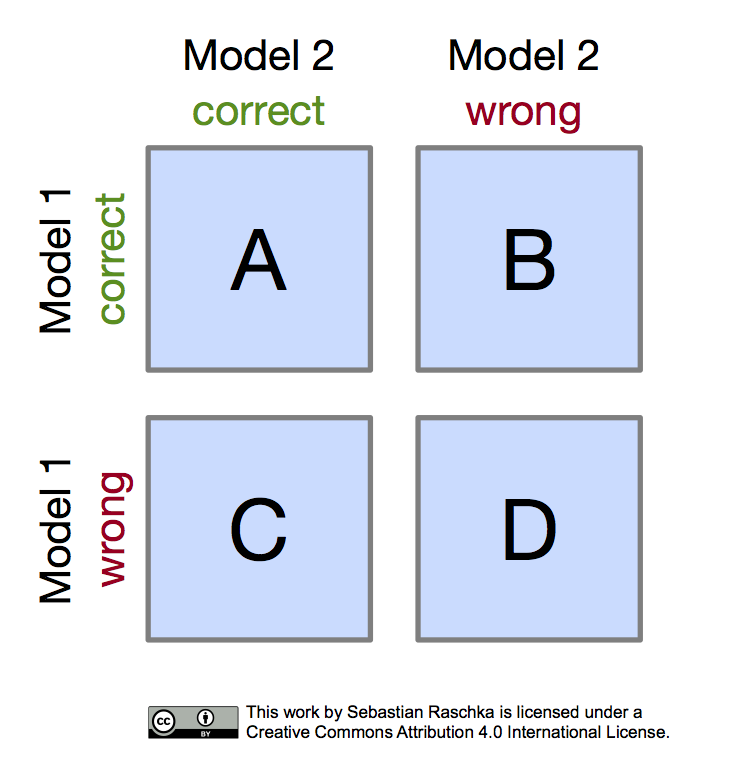

In [ ]:
import statsmodels
from statsmodels.stats.contingency_tables import mcnemar

results = []
combinations = [(('gbm', 'gbm(classical)'), ('fttransformer', 'fttransformer(classical)')),
                (('gbm', 'gbm(classical-size)'), ('fttransformer', 'fttransformer(classical-size)')),
                (('gbm', 'gbm(ml)'), ('fttransformer', 'fttransformer(ml)'))]
significance = 0.05

def get_contingency_table(Y, ground_truth, model_1, model_2):

    Y_ = Y[[ground_truth, model_1, model_2]].copy().astype(int)

    c_0_0 = np.where((Y_[model_1] == Y_[ground_truth]) & (Y_[model_2] == Y_[ground_truth]), 1, 0).sum()
    c_0_1 = np.where((Y_[model_1] == Y_[ground_truth]) & (Y_[model_2] != Y_[ground_truth]), 1, 0).sum()
    c_1_0 = np.where((Y_[model_1] != Y_[ground_truth]) & (Y_[model_2] == Y_[ground_truth]), 1, 0).sum()
    c_1_1 = np.where((Y_[model_1] != Y_[ground_truth]) & (Y_[model_2] != Y_[ground_truth]), 1, 0).sum()
    
    contingency_table = [[c_0_0, c_0_1],[c_1_0, c_1_1]]

    return np.array(contingency_table)

    
for combination in tqdm(combinations):
    contingency_table = get_contingency_table(Y, 'buy_sell', combination[0], combination[1])
    test = mcnemar(contingency_table, exact=False, correction=True)
    
    results.append({"contingency_table": contingency_table, "model_1": combination[0], "model_2": combination[1], "statistic": test.statistic, "p-value": test.pvalue, "significant": test.pvalue < significance})
    


In [ ]:
pd.DataFrame(results).to_csv("cboe.csv")

## High Level Overview

In [ ]:
%%script false --no-raise-error
X_print["all"] = "all"
X_print["date"] = X_print["QUOTE_DATETIME"].dt.date

In [ ]:
%%script false --no-raise-error
if EXCHANGE == "ise":
    bins_dt = [pd.Timestamp("2000-01-01 00:00:00"), pd.Timestamp("2013-10-24 23:59:00"), pd.Timestamp("2015-11-05 23:59:00"),pd.Timestamp("2099-12-31 23:59:59")]
    labels_dt = ["train", "val", "test"]
else:
    bins_dt = [pd.Timestamp("2000-01-01 00:00:00"), pd.Timestamp("2015-11-05 23:59:00"), pd.Timestamp("2099-12-31 23:59:59")]
    labels_dt = ["unused", "test"]

X_print["date"] = pd.to_datetime(X_print['date'])

X_print["set"] = pd.cut(X_print['date'], bins=bins_dt, labels=labels_dt)

In [ ]:
%%script false --no-raise-error
X_print = pd.concat([X_print, results_data], axis=1)

## Accuracy Over Time

In [ ]:
%%script false --no-raise-error
results = []
for classifier in tqdm(classifiers):
    res = (
        X_print.groupby(["date"])[["buy_sell", classifier]]
        .apply(
                lambda x: accuracy_score(x["buy_sell"].astype("int8"), x[classifier])
        )
        .mul(100)
        .rename(classifier)
    )
    results.append(res)

In [ ]:
%%script false --no-raise-error
accuracies_over_time = pd.concat(results, axis=1)
accuracies_over_time.columns = accuracies_over_time.columns.get_level_values(1)

In [ ]:
%%script false --no-raise-error
accuracies_over_time.head()

In [ ]:
%%script false --no-raise-error
output_path = (
    f"gs://thesis-bucket-option-trade-classification/data/results/{KEY}-classical-accurcies-over-time.parquet"
)
accuracies_over_time.to_parquet(output_path)


In [ ]:
%%script false --no-raise-error
# Log the artifact to save it as an output of this run
result_set = wandb.Artifact(name=f"{KEY}-classical-accurcies-over-time", type="results")
result_set.add_reference(output_path, name="results")
run.log_artifact(result_set)

wandb.finish()

### Robustness Checks

In [ ]:
# %%script false --no-raise-error
# prepare columns for printing
X_print["ttm"] = (
    X_print["EXPIRATION"].dt.to_period("M")
    - X_print["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)

X_print["year"] = X_print["QUOTE_DATETIME"].dt.year

bins_tradesize = [-1, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
X_print["TRADE_SIZE_binned"] = pd.cut(
    X_print["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

# p. 38
bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
X_print["year_binned"] = pd.cut(X_print["year"], bins_years, labels=year_labels)

# p. 37
bins_ttm = [-1, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "<= 1",
    "(1-2]",
    "(2-3]",
    "(3-6]",
    "(6-12]",
    "> 12",
]
X_print["ttm_binned"] = pd.cut(X_print["ttm"], bins_ttm, labels=ttm_labels)

# Security type
# see 3.0a-mb-explanatory-data-analysis.ipynb
X_print["issue_type"] = X_print["issue_type"].map(
    {
        "0": "Stock option",
        "A": "Index option",
        "7": "Others",
        "F": "Others",
        "%": "Others",
        " ": "Others",
    }
)

# Moneyness p. 38
bins_myn = [-1, 0.7, 0.9, 1.1, 1.3, np.inf]
myn_labels = [
    "<= 0.7",
    "(0.7-0.9]",
    "(0.9-1.1]",
    "(1.1-1.3]",
    "> 1.3",
]
X_print["myn_binned"] = pd.cut(X_print["myn"], bins_myn, labels=myn_labels)

# mid p. 31 + extra category for unknowns
ask = X_print["ask_ex"]
bid = X_print["bid_ex"]
trade_price = X_print["TRADE_PRICE"]

# require ask >= bid
mid = np.where(ask >= bid, (ask + bid) * 0.5, np.nan)

prox_quotes = np.where(
    trade_price == mid,
    0,  # at mid
    np.where(
        (bid < trade_price) & (trade_price < ask),
        1,  # inside
        np.where(
            (trade_price == bid) | (ask == trade_price),
            2,  # at quotes
            np.where((trade_price < bid) | (ask < trade_price), 3, 4),
        ),
    ),
)  # outside + unclassifiable

bins_prox = [-np.inf, 0, 1, 2, 3, 4]
prox_labels = [
    "at mid",
    "inside",
    "at quotes",
    "outside",
    "unknown",
]

X_print["prox_q_binned"] = pd.cut(prox_quotes, bins_prox, labels=prox_labels)
X_print["mid"] = mid

# clean up empty buckets, as it causes empty grouping in result set generation
X_print["year_binned"] = X_print["year_binned"].cat.remove_unused_categories()
X_print["myn_binned"] = X_print["myn_binned"].cat.remove_unused_categories()
X_print["ttm_binned"] = X_print["ttm_binned"].cat.remove_unused_categories()
X_print["prox_q_binned"] = X_print["prox_q_binned"].cat.remove_unused_categories()

X_print["all"] = "all"

X_print.drop(
    columns=[
        "EXPIRATION",
        "QUOTE_DATETIME",
        # "TRADE_SIZE",
        "ttm",
        "myn",
        "year",
    ],
    inplace=True,
)


In [ ]:
X_print = pd.concat([X_print, results_data], axis=1)


In [ ]:
X_print.head().T

In [ ]:
X_print[X_print["prox_q_binned"]=="inside"].head(64).index

In [ ]:
%%script false --no-raise-error

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cf_matrices = []

for classifier in classifiers:
    mat = confusion_matrix(X_print["buy_sell"].astype("int8"), X_print[classifier], labels=[-1,1])
    cf_matrices.append(mat)
    
cfs = pd.Series(index=classifiers, data=cf_matrices, name="cf")

output_path = (
    f"gs://thesis-bucket-option-trade-classification/data/results/{KEY}-confusion-matrices.pickle"
)
cfs.to_frame().to_pickle(output_path)

result_set = wandb.Artifact(name=f"{KEY}-confusion-matrices", type="results")
result_set.add_reference(output_path, name="results")
run.log_artifact(result_set)

wandb.finish()

## Accuracy Calculation

In [ ]:
%%script false --no-raise-error
criterions = ["set", "all"]

In [ ]:
# FIXME: Find better approach
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

result_dfs = []

for criterion in tqdm(criterions):
    results = []
    for classifier in classifiers:
        res = (
            X_print.groupby([criterion])[["buy_sell", classifier]]
            .apply(
                lambda x: accuracy_score(x["buy_sell"].astype("int8"), x[classifier])
            )
            .mul(100)
            .rename(classifier)
        )
        #         acc_tot = accuracy_score(
        #             X_print["buy_sell"].astype("int8"), X_print[classifier]
        #         )

        #         res.loc["all"] = acc_tot * 100

        res.index.name = LUT_INDEX.get(criterion)
        results.append(res)

    # save aggregated results
    result_df = pd.concat(results, axis=1).T
    # result_df.style.pipe(
    #     set_tex_style,
    #     caption=(f"long-tbd", "short-tbd"),
    #     label=f"{KEY.lower()}-{criterion.lower()}",
    # )

    # store all result sets for later use
    result_dfs.append(result_df)


In [ ]:
%%script false --no-raise-error
keys = ["set", "all"]
master = pd.concat(result_dfs, axis=1, keys=keys).T

In [ ]:
master = pd.concat(result_dfs, axis=1, keys=list(LUT_INDEX.values())).T

In [ ]:
master.style.pipe(
    set_tex_style,
    caption=("master-long", "master-short"),
    label=f"{KEY}-master",
    bold_axis=0,
)


In [ ]:
master

## Effective Spread 💴

In [ ]:
# mid p. 31 + extra category for unknowns
ask = X_print["ask_ex"]
bid = X_print["bid_ex"]
trade_price = X_print["TRADE_PRICE"]

# require ask >= bid
mid = np.where(ask >= bid, (ask + bid) * 0.5, np.nan)

results = []

# calculate true rel effective spread but not aggregated, convert to %
es_true = effective_spread(X_print["buy_sell"], X_print["TRADE_PRICE"], mid, mode="none")
nom_true = np.nanmean(es_true)

eps_true = np.empty(es_true.shape)
np.divide(es_true, mid, out=eps_true, where=mid != 0)
rel_true = np.nanmean(eps_true)


for classifier in tqdm(classifiers):

    # calculate pred rel effective spread but not aggregated convert to %
    es_pred = effective_spread(X_print[classifier], X_print["TRADE_PRICE"], mid, mode="none")
    
    eps_pred = np.empty(es_pred.shape)
    np.divide(es_pred, mid, out=eps_pred, where=mid != 0)

    wilcoxon_res  = wilcoxon(eps_pred, eps_true, nan_policy="omit", zero_method="zsplit")

    res = pd.Series(
            {
                "nom_pred": np.nanmean(es_pred),
                "rel_pred": np.nanmean(eps_pred),
                "statistic":wilcoxon_res.statistic,
                "pvalue":wilcoxon_res.pvalue,
            }, name=classifier
        )
    results.append(res)

true_eff = pd.Series({"nom_pred":nom_true, "rel_pred": rel_true, "statistic":np.NaN, "pvalue":np.NaN}, name="true_eff")

results.append(true_eff)

results = pd.concat(results, axis=1)

In [ ]:
results.T.style.format("{:.3f}")


In [ ]:
results.T.style.to_latex(
    f"../reports/Content/{KEY}-eff-spread.tex",
    siunitx=True,
    position_float="centering",
    hrules=True,
    clines="skip-last;data",
    label=f"tab:eff-{KEY}",
    caption=(f"long-eff-{KEY}", f"short-eff-{KEY}"),
    convert_css=True,
)


## Diffs 🔄️

In [ ]:
master.columns.tolist()

In [ ]:
# classical baselines
view = [("gbm", "gbm(semi-classical)"), ("gbm", "gbm(semi-classical-size)"), ("gbm", "gbm(semi-ml)")]

base = master[
    [
        ("classical", "quote(best)->quote(ex)->rev_tick(all)"),
        (
            "classical",
            "trade_size(ex)->quote(best)->quote(ex)->depth(best)->depth(ex)->rev_tick(all)",
        ),
        (
            "classical",
            "trade_size(ex)->quote(best)->quote(ex)->depth(best)->depth(ex)->rev_tick(all)",
        ),
    ]
]

# my ml models
revised = master[view]


In [ ]:
def combine_results(revised: pd.DataFrame, base: pd.DataFrame) -> pd.DataFrame:
    """
    Generate print layout like in Grauer et al.

    https://tex.stackexchange.com/questions/430283/table-with-numbers-in-parentheses-in-siunitx/430290#430290

    # see p. https://texdoc.org/serve/siunitx/0
    """
    # first, second layer of colum index
    c_1 = revised.columns.get_level_values(1)
    c_2 = ["nom"]
    midx = pd.MultiIndex.from_product([c_1, c_2])

    # copy data from revised add as (column, "nom")
    combo = pd.DataFrame(revised.values, index=revised.index, columns=midx)

    for i, mul_col in enumerate(combo.columns):

        combo[(mul_col[0], "pm")] = (combo[mul_col] - base.iloc[:, i]).round(2)
        combo.sort_index(axis=1, inplace=True)

    return combo


In [ ]:
diff = combine_results(revised, base)

In [ ]:
diff.style.to_latex(
    f"../reports/Content/diff-{KEY}.tex",
    siunitx=True,
    position_float="centering",
    hrules=True,
    clines="skip-last;data",
    label=f"tab:diff-{KEY}",
    caption=(f"long-diff-{KEY}", f"short-diff-{KEY}"),
    convert_css=True,
)


In [ ]:
diff
